## Exercise-1: Training Deep Neural Network on MNIST
### Q1.1 Report the obtained test accuracy.
We start by importing the necessary libraries and setting random seeds to 42 for reproducibility. If the device is running on Apple Silicon, we use Metal Performance Shaders (MPS) to speed up training.

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import copy 

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

# Use Metal Performance Shaders (MPS) GPU if available on Apple Silicon
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: mps


Next, we load the MNIST dataset and apply standard transforms to preprocess the images.

In [ ]:
# Define transforms for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST standardization
])

# Import MNIST dataset
full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
full_test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

We use a small subset of MNIST, taking the first 1000 training samples and 200 test samples. We then split the training subset into training and validation sets. Finally, we create DataLoaders with a batch size of 32 to handle batching during training and evaluation.

In [ ]:
# Restrict to small subset for controlled experiment
temp_dataset = Subset(full_train, range(1000))  # use only first 1000 train samples
test_dataset  = Subset(full_test, range(200))   # use first 200 test samples

# This ensures that random_split produces the same train/val split every run
generator = torch.Generator().manual_seed(seed)
train_dataset, val_dataset = random_split(temp_dataset, [800, 200], generator=generator)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

We define a custom DNN by creating a class that extends `nn.Module`. It has three hidden layers with 64 neurons each, uses ELU activations, and outputs 10 neurons for the 10 MNIST classes. He normal initialization is applied to all linear layers for better convergence.

In [62]:
class MNIST_DNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),        
            nn.Linear(28*28, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 10)
        )

        # Apply He normal initialization to all Linear layers
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.model(x)

We create a `train_model()` function to handle training and validation. It tracks losses and accuracies, uses global device/optimizer/criterion, and implements early stopping to keep the best model weights.

In [ ]:
def train_model(model, train_loader, val_loader, epochs, patience):  
    global device
    global optimizer
    global criterion

    best_val_loss = float('inf')
    counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        # ----- Training -----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * x_batch.size(0)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        # ----- Validation -----
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)

                running_loss += loss.item() * x_batch.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        epoch_val_loss = running_loss / total
        epoch_val_acc = correct / total

        # ----- Save metrics -----
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

        # ----- Early stopping -----
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

We now train the model using the Nadam optimizer with a learning rate of 0.001 and sparse categorical cross-entropy loss. Early stopping monitors the validation loss with a patience of 5 epochs and restores the best weights. Training runs for up to 50 epochs.

In [64]:
model = MNIST_DNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 50
patience = 5  # for early stopping
best_val_loss = float('inf')
counter = 0   # counts epochs without improvement
best_model_wts = copy.deepcopy(model.state_dict())

model, history = train_model(model, train_loader, val_loader, epochs, patience)

Epoch 1/50 | Train Loss: 1.5316, Acc: 0.5200 | Val Loss: 0.8568, Acc: 0.7250
Epoch 2/50 | Train Loss: 0.5479, Acc: 0.8438 | Val Loss: 0.6026, Acc: 0.8100
Epoch 3/50 | Train Loss: 0.2914, Acc: 0.9175 | Val Loss: 0.5422, Acc: 0.8450
Epoch 4/50 | Train Loss: 0.1792, Acc: 0.9463 | Val Loss: 0.5029, Acc: 0.8500
Epoch 5/50 | Train Loss: 0.1108, Acc: 0.9738 | Val Loss: 0.5408, Acc: 0.8400
Epoch 6/50 | Train Loss: 0.0633, Acc: 0.9912 | Val Loss: 0.5163, Acc: 0.8500
Epoch 7/50 | Train Loss: 0.0402, Acc: 0.9975 | Val Loss: 0.5215, Acc: 0.8600
Epoch 8/50 | Train Loss: 0.0262, Acc: 1.0000 | Val Loss: 0.5276, Acc: 0.8600
Epoch 9/50 | Train Loss: 0.0190, Acc: 1.0000 | Val Loss: 0.5326, Acc: 0.8700
Early stopping triggered after 9 epochs.


We visualize training results using `plotAccuracyAndLoss(history)`, which shows loss and accuracy for both training and validation sets.

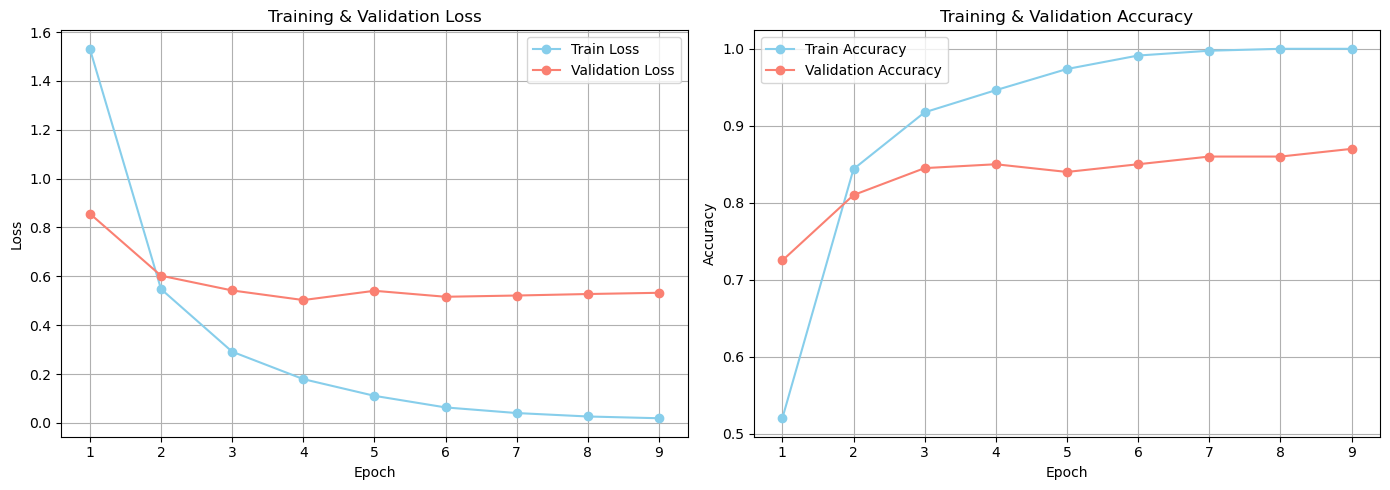

In [66]:
def plotAccuracyAndLoss(history):

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)  # Start from epoch 1

    # ----- Left subplot: Loss -----
    ax[0].plot(epochs, history['train_loss'], label='Train Loss', color='skyblue', marker='o')
    ax[0].plot(epochs, history['val_loss'], label='Validation Loss', color='salmon', marker='o')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)

    # ----- Right subplot: Accuracy -----
    ax[1].plot(epochs, history['train_acc'], label='Train Accuracy', color='skyblue', marker='o')
    ax[1].plot(epochs, history['val_acc'], label='Validation Accuracy', color='salmon', marker='o')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

plotAccuracyAndLoss(history)

Upon analyzing the trends, we can observe that the validation accuracy stops improving meaningfully after epoch 4. This is expected, as we are training and validating on a small subset of the MNIST dataset. With such a limited dataset, the model might not be able to generalize well beyond the training data, which can lead to a plateau in performance.

In [75]:
def evaluateWithTestSet(model, test_loader):
    global device
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy_percentage = (correct / total) * 100
    print(f"Test Accuracy: {test_accuracy_percentage:.2f}%")

# Evaluate the test accuracy
evaluateWithTestSet(model, test_loader)

Test Accuracy: 87.50%


The model achieves a test accuracy of 87.5%. This shows that the DNN captures some patterns in the data, but performance could likely improve with a larger dataset, as training plateaus quickly.

## Exercise-2: Training Deep Neural Network on CIFAR-10
### Q2.1 Report the obtained test accuracy.
